<a href="https://colab.research.google.com/github/AlirezaAhadipour/Time-Series-Analysis/blob/main/FordA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the dataset

For description about the dataset, please refer to:

http://www.j-wichard.de/publications/FordPaper.pdf

In [2]:
# FordA Dataset
root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

train_file = root_url + "FordA_TRAIN.tsv"
test_file = root_url + "FordA_TEST.tsv"

train_data = pd.read_csv(train_file, delimiter="\t", header=None)
test_data = pd.read_csv(test_file, delimiter="\t", header=None)

X_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values

X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

In [3]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,500
0,-1,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,...,1.120756,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343
1,1,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,...,0.386403,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086
2,-1,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,...,0.394463,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391
3,-1,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,...,-0.952804,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736
4,-1,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,...,0.776188,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213


In [4]:
print(f" There are {X_train.shape[0]} examples in the train set and {X_test.shape[0]} in the test set!")

 There are 3601 examples in the train set and 1320 in the test set!


# Visualize the data

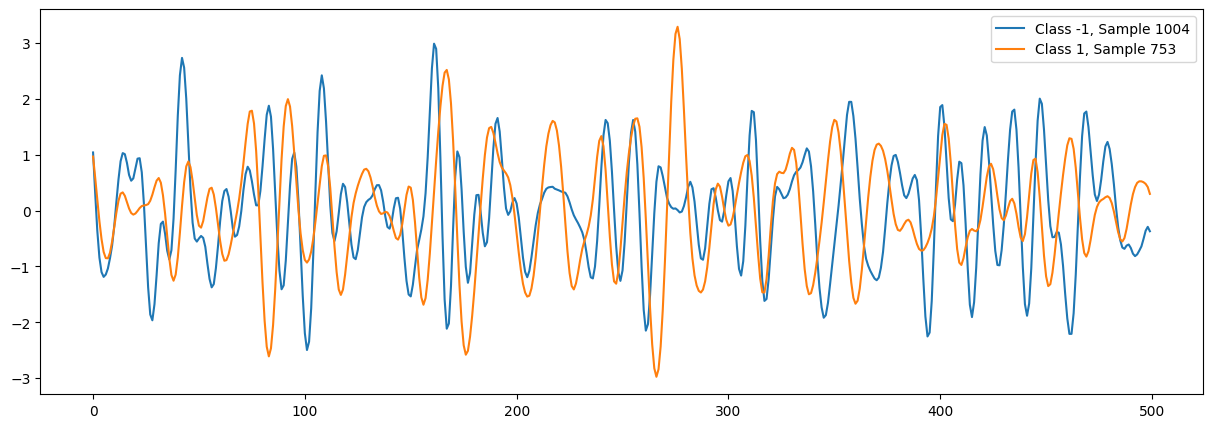

In [5]:
# Plot Samples

classes = np.unique(np.concatenate((y_train, y_test), axis=0))
num_samples_per_class = 1  # Number of samples to plot per class

plt.figure(figsize=(15, 5))
for c in classes:
    c_x_train = X_train[y_train == c]
    sample_indices = np.random.choice(c_x_train.shape[0], size=num_samples_per_class, replace=False)
    for idx in sample_indices:
        plt.plot(c_x_train[idx], label="Class " + str(c) + ", Sample " + str(idx))

plt.legend(loc="best")
plt.show()

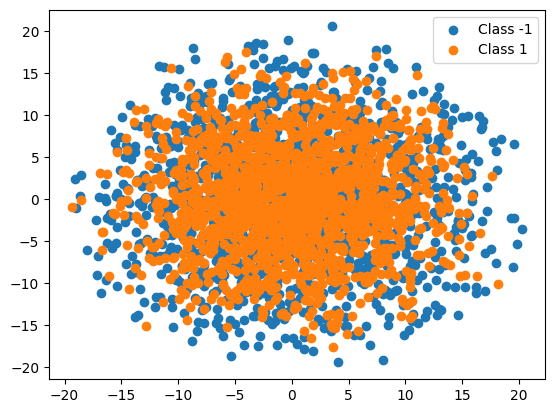

In [6]:
# Dimentionality reduction visualization

from sklearn.decomposition import PCA

# Perform PCA to reduce dimensionality to 2
pca = PCA(n_components=2)
X_train_reduced = pca.fit_transform(X_train)

classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    class_indices = np.where(y_train == c)
    plt.scatter(X_train_reduced[class_indices, 0], X_train_reduced[class_indices, 1], label="Class " + str(c))

plt.legend(loc="best")
plt.show()

# Mean and Variance

In [7]:
# Select a couple of samples from the dataset
sample_indices = [0, 100, 1000]  # Example indices of the samples
selected_samples = X_train[sample_indices]

# Calculate mean and standard deviation
mean_values = np.mean(selected_samples, axis=1)
std_values = np.std(selected_samples, axis=1)

# Print the calculated statistics
for i, index in enumerate(sample_indices):
    print(f"Sample {index}: Mean={round(mean_values[i], 2)}, Standard Deviation={round(std_values[i], 2)}")


Sample 0: Mean=-0.0, Standard Deviation=1.0
Sample 100: Mean=0.0, Standard Deviation=1.0
Sample 1000: Mean=-0.0, Standard Deviation=1.0


In [8]:
mean_value = round(np.mean(X_train), 2)
std_value = round(np.std(X_train), 2)

print(f"Mean of X_train: {mean_value}")
print(f"Standard Deviation of X_train: {std_value}")

Mean of X_train: -0.0
Standard Deviation of X_train: 1.0


So, all the samples have a mean of 0 and a standard deviation of 1; that is, the dataset is z-score normalized.

# Pre-processing

In [9]:
# Reshape the dataset from 2D to 3D

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [10]:
# convert labels to 0 and 1

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [12]:
# shuffle the train set

# Generate a random permutation of indices
indices = np.random.permutation(len(X_train))

# Shuffle X_train and y_train using the same indices
X_train = X_train[indices]
y_train = y_train[indices]

# 1D CNN

In [23]:
# Build the model

model = tf.keras.Sequential()

# 1st conv layer
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same", input_shape=X_train.shape[1:]))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
# 2nd conv layer
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
# 3rd conv layer
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
# add pooling layer
model.add(tf.keras.layers.GlobalAveragePooling1D())
# add a dense output layer
model.add(tf.keras.layers.Dense(2, activation="sigmoid"))

In [24]:
# Train the model

epochs = 500
batch_size = 32

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
90/90 [==============================] - 13s 12ms/step - loss: 0.5832 - sparse_categorical_accuracy: 0.6785 - val_loss: 0.7722 - val_sparse_categorical_accuracy: 0.4785 - lr: 0.0010
Epoch 2/500
90/90 [==============================] - 1s 7ms/step - loss: 0.4598 - sparse_categorical_accuracy: 0.7812 - val_loss: 0.7529 - val_sparse_categorical_accuracy: 0.4785 - lr: 0.0010
Epoch 3/500
90/90 [==============================] - 1s 7ms/step - loss: 0.4307 - sparse_categorical_accuracy: 0.7844 - val_loss: 0.7065 - val_sparse_categorical_accuracy: 0.4660 - lr: 0.0010
Epoch 4/500
90/90 [==============================] - 1s 7ms/step - loss: 0.4295 - sparse_categorical_accuracy: 0.7816 - val_loss: 0.7409 - val_sparse_categorical_accuracy: 0.4771 - lr: 0.0010
Epoch 5/500
90/90 [==============================] - 1s 7ms/step - loss: 0.4125 - sparse_categorical_accuracy: 0.7951 - val_loss: 0.5847 - val_sparse_categorical_accuracy: 0.6546 - lr: 0.0010
Epoch 6/500
90/90 [===================

So at epoch 200 we have early stopping; that is, after that the model was going to overfit the training set.

In [26]:
# Evaluate the model

model = tf.keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 [==============================] - 0s 5ms/step - loss: 0.0990 - sparse_categorical_accuracy: 0.9689
Test accuracy 0.9689394235610962
Test loss 0.0990271121263504


The test accuracy is about 97%, which is pretty descent.

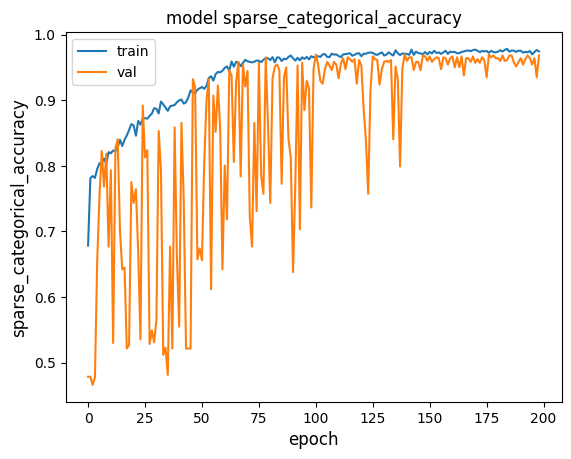

In [28]:
# Plot th loss

metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()